### get train/test task distribution

In [26]:
import os
import re

COMP_PATH = '../'
all_tasks = ['tea', 'cereals', 'coffee', 'friedegg', 'juice', 'milk', 
             'sandwich', 'scrambledegg', 'pancake', 'salat']

# get train tasks statistics
train_split_load = os.path.join(COMP_PATH, 'splits/train.split1.bundle') #Train Split
train_file_ptr = open(train_split_load, 'r')
train_content_all = train_file_ptr.read().split('\n')[1:-1]
train_content_all = [x.strip('./data/groundTruth/') + 't' for x in train_content_all]
# print(train_content_all)
train_task = [re.findall('_([a-z]*?).txt', t)[0] for t in train_content_all]
train_task_dict = {task:0 for task in all_tasks}
for t in train_task:
    train_task_dict[t] += 1
print('train\n', train_task_dict)

# get test tasks statistics
test_split_load = os.path.join(COMP_PATH, 'splits/test.split1.bundle') #Test Split
test_file_ptr = open(test_split_load, 'r')
test_content_all = test_file_ptr.read().split('\n')[1:-1]
test_content_all = [x.strip('./data/groundTruth/') + 't' for x in test_content_all]
# print(test_content_all)
test_task = [re.findall('_([a-z]*?).txt', t)[0] for t in test_content_all]
test_task_dict = {task:0 for task in all_tasks}
for t in test_task:
    test_task_dict[t] += 1
print('\n\ntest\n',test_task_dict)

train
 {'tea': 154, 'cereals': 157, 'coffee': 145, 'friedegg': 146, 'juice': 146, 'milk': 156, 'sandwich': 142, 'scrambledegg': 140, 'pancake': 135, 'salat': 139}


test
 {'tea': 30, 'cereals': 27, 'coffee': 22, 'friedegg': 27, 'juice': 16, 'milk': 31, 'sandwich': 27, 'scrambledegg': 26, 'pancake': 22, 'salat': 24}


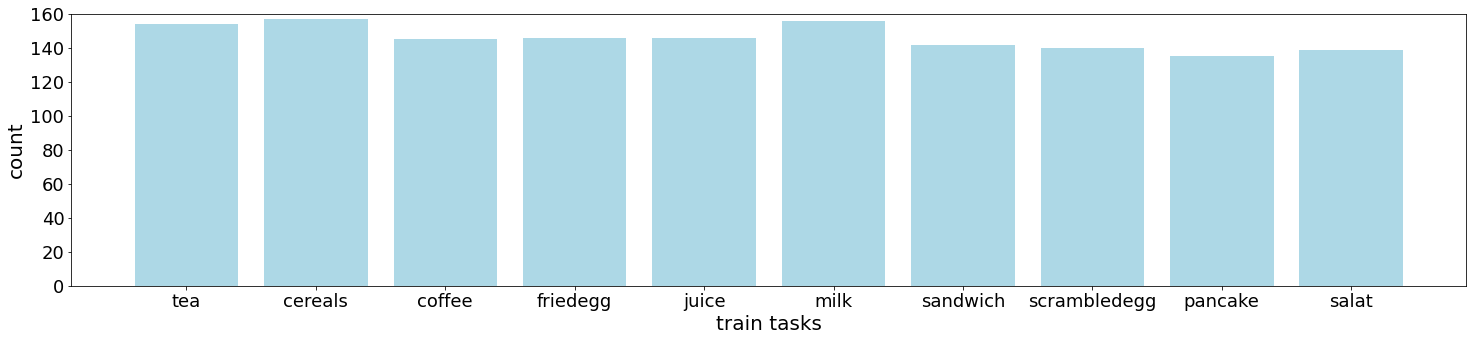

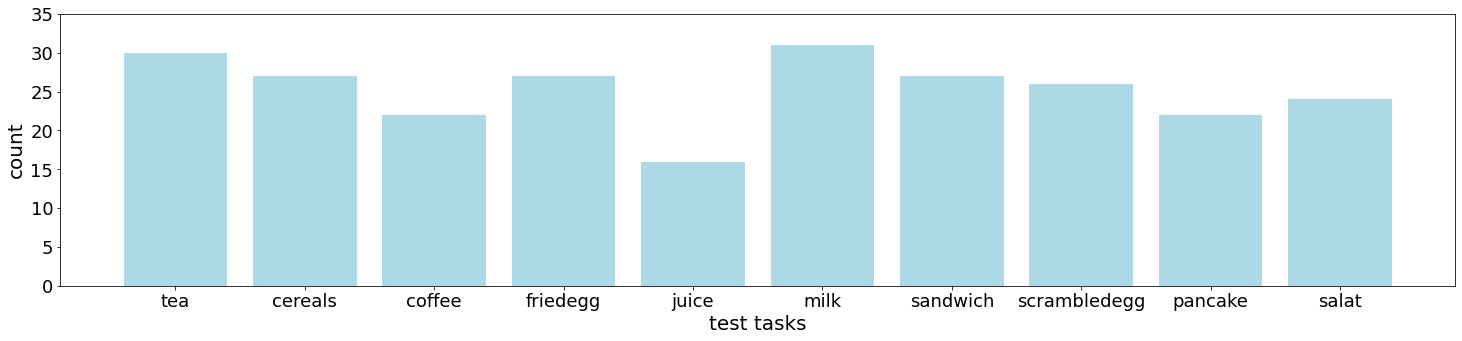

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,5))

plt.bar(list(train_task_dict.keys()), list(train_task_dict.values()), color='lightblue', linewidth=1.0)

plt.xlabel('train tasks', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.ylim(0, 160)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

plt.figure(figsize=(25,5))

plt.bar(list(test_task_dict.keys()), list(test_task_dict.values()), color='lightblue', linewidth=1.0)

plt.xlabel('test tasks', fontsize=20)
plt.ylabel('count', fontsize=20)
plt.ylim(0, 35)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.show()

### get the statistic info of each labels' length

In [1]:
# -*- coding: utf-8 -*-

import os  
import numpy as np
import os.path
import matplotlib.pyplot as plt


def get_labels_info(split_load, actions_dict, GT_folder, DATA_folder, statistics = 'all'):
    """
    main func, other funcs are called by this func
    """
    file_ptr = open(split_load, 'r')
    content_all = file_ptr.read().split('\n')[1:-1]
    content_all = [x.strip('./data/groundTruth/') + 't' for x in content_all]
    
    data_breakfast = []
    labels_breakfast = []
    for content in content_all:
        file_ptr = open(GT_folder + content, 'r')
        curr_gt = file_ptr.read().split('\n')[:-1]

        label_curr_video = []
        for iik in range(len(curr_gt)):
            label_curr_video.append(actions_dict[curr_gt[iik]])    # actions_dict {'SIL': 0, 'pour_cereals': 1, 'pour_milk': 2,

        labels_breakfast.append(label_curr_video)

    label_len_in_splits = get_all_label_len_list(labels_breakfast)
    # label_len_in_splits: list, len: num of the video splits;
    # each element of list 'label_len_in_splits' is also list, contains each labels and its length in this split
    # eg. [[[0, 9], [1, 260]], [[0, 48], [10, 328]]...]
    # [[0, 9], [1, 260]] stands for the 1st video split, and [0, 9] means label 0 has length 9
    
    if statistics == 'all':
        label_len_in_all_splits = []
        for split in label_len_in_splits:
            label_len_in_all_splits.extend(split)
        # label_len_in_all_splits: a list contain each label and its length, every ele: [label,len]
        
        label_len_statistics_dict = get_label_len_statistics(label_len_in_all_splits)
        # label_len_statistics_dict: get all statistic features of labels' length
        # eg. {0: {'mean': 79.96014234875445, 'max': 2644, 'min': 2, 'num': 2810},...}
        # key: label, value: the max,min,mean of length and num stands for occurances of the label
        
        return label_len_in_splits, label_len_in_all_splits, label_len_statistics_dict
        
def get_label_len_statistics(label_len_list):
    """
    get all statistic features of labels' length
    """
    label_len_dict = {}
    for i in label_len_list:
        label = i[0]
        label_len = i[1]
        if label in label_len_dict:
            label_len_dict[label].append(label_len)
        elif label not in label_len_dict:
            label_len_dict[label] = [label_len]
    
    label_len_statistics_dict = {}
    for label, len_list in label_len_dict.items():
        label_len_statistics_dict[label] = {'mean': np.mean(len_list), 'max': max(len_list), 'min': min(len_list), 'num': len(len_list)}
    
    return label_len_statistics_dict

    
def get_all_label_len_list(data_labels):
    labels_uniq = []
    labels_uniq_loc = []
    label_len_in_splits = []
    for kki in range(0, len(data_labels) ):
        label_len_dict = {}
        uniq_group, indc_group = get_label_length_seq(data_labels[kki])
        label_len_in_splits.append(get_label_len(uniq_group, indc_group))
        labels_uniq.append(uniq_group)
        labels_uniq_loc.append(indc_group)

    return label_len_in_splits


def get_label_length_seq(content):
    label_seq = []
    length_seq = []
    start = 0
    length_seq.append(0)
    for i in range(len(content)):
        if content[i] != content[start]:
            #print(content[i])
            label_seq.append(content[start])
            length_seq.append(i)
            start = i
    label_seq.append(content[start])
    length_seq.append(len(content))
    
#     if content[-1] != 0:
#         label_seq.append(content[-1])
    
    return label_seq, length_seq


def get_label_len(uniq_label_list, indc_list):
    label_len_list = []
    for i,label in enumerate(uniq_label_list):
        label_len = indc_list[i+1] - indc_list[i]
        label_len_list.append([label, label_len])
    return label_len_list
        

def read_mapping_dict(mapping_file):
    file_ptr = open(mapping_file, 'r')
    actions = file_ptr.read().split('\n')[:-1]

    actions_dict=dict()
    for a in actions:
        actions_dict[a.split()[1]] = int(a.split()[0])

    return actions_dict


COMP_PATH = ''

train_split =  os.path.join(COMP_PATH, 'splits/train.split1.bundle')
test_split  =  os.path.join(COMP_PATH, 'splits/test.split1.bundle')
GT_folder   =  os.path.join(COMP_PATH, 'groundTruth/')
DATA_folder =  os.path.join(COMP_PATH, 'data/')
mapping_loc =  os.path.join(COMP_PATH, 'splits/mapping_bf.txt')

actions_dict = read_mapping_dict(mapping_loc)
label_len_in_splits, label_len_in_all_splits, label_len_statistics_dict = get_labels_info(train_split, actions_dict, 
                                                                                          GT_folder, DATA_folder)
print("statistic dict of each labels's length\n")
for i in label_len_statistics_dict.items():
    print(i)

statistic dict of each labels's length

(0, {'mean': 79.96014234875445, 'max': 2644, 'min': 2, 'num': 2810})
(1, {'mean': 284.21019108280257, 'max': 800, 'min': 131, 'num': 157})
(2, {'mean': 208.25214408233276, 'max': 979, 'min': 62, 'num': 583})
(10, {'mean': 219.875, 'max': 491, 'min': 76, 'num': 120})
(11, {'mean': 348.08788598574824, 'max': 1393, 'min': 79, 'num': 421})
(12, {'mean': 266.22983870967744, 'max': 777, 'min': 47, 'num': 248})
(13, {'mean': 1519.0, 'max': 4591, 'min': 244, 'num': 170})
(14, {'mean': 171.657223796034, 'max': 1293, 'min': 30, 'num': 353})
(15, {'mean': 233.1865671641791, 'max': 771, 'min': 63, 'num': 268})
(18, {'mean': 95.09803921568627, 'max': 205, 'min': 8, 'num': 51})
(19, {'mean': 153.7173913043478, 'max': 390, 'min': 69, 'num': 138})
(20, {'mean': 677.7094972067039, 'max': 1771, 'min': 100, 'num': 179})
(21, {'mean': 197.43859649122808, 'max': 890, 'min': 70, 'num': 171})
(24, {'mean': 309.1829268292683, 'max': 739, 'min': 110, 'num': 164})
(25, {'

### graph of statistic info for label length

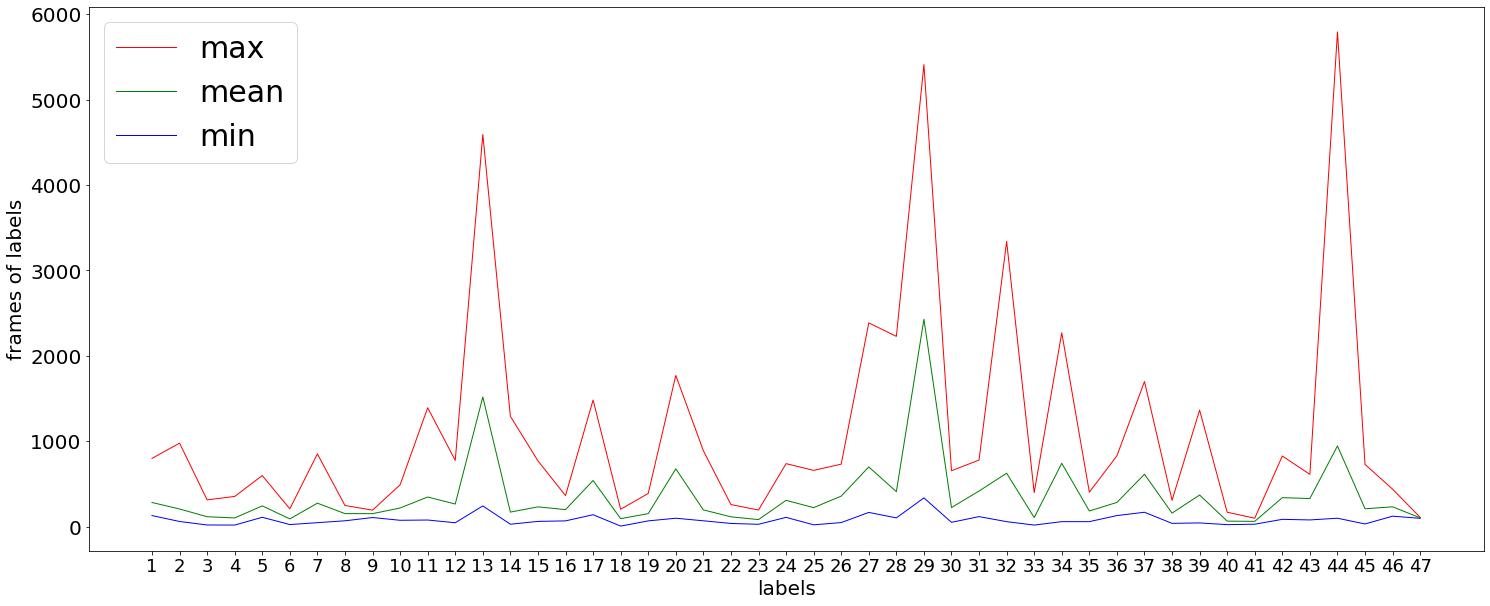

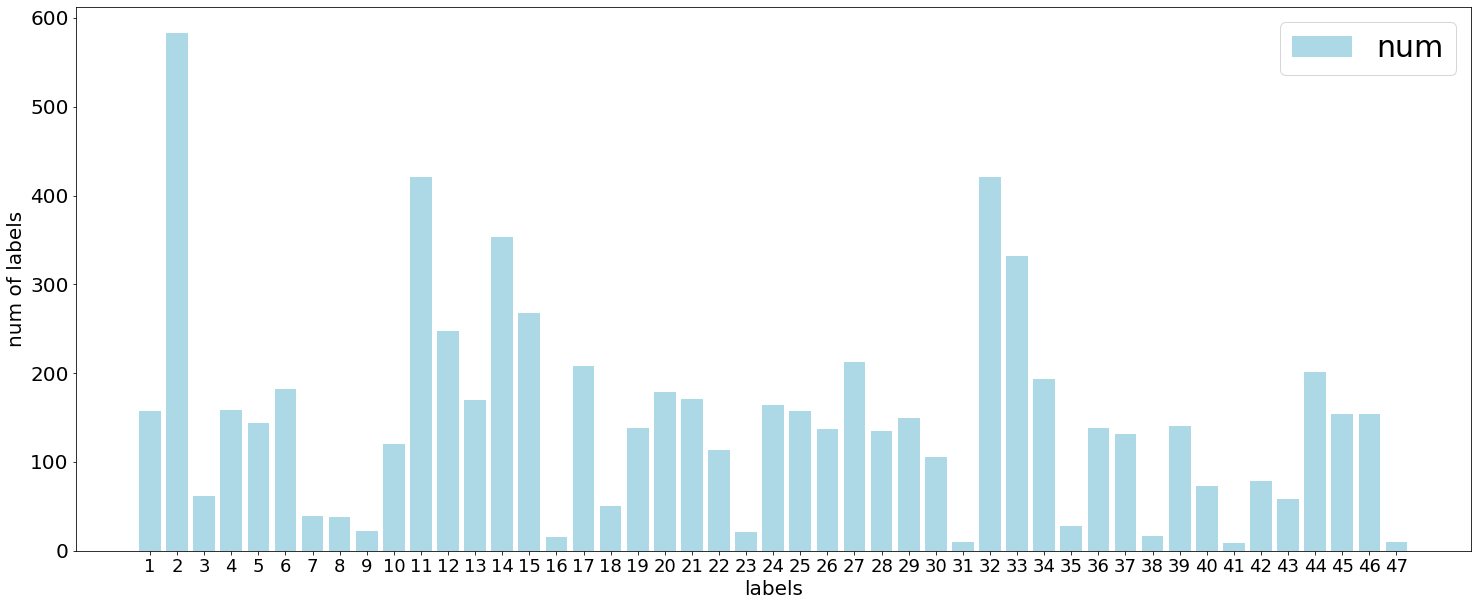

In [5]:
def draw_label_len(len_statistics_dict):
    labels_list = []
    mean_list = []
    max_list = []
    min_list = []
    count_list = []
    labels_list = list(len_statistics_dict.keys())
    labels_list.sort()
    for label in labels_list:
        mean_list.append(len_statistics_dict[label]['mean'])
        max_list.append(len_statistics_dict[label]['max'])
        min_list.append(len_statistics_dict[label]['min'])
        count_list.append(len_statistics_dict[label]['num'])
        
    plt.figure(figsize=(25,10))
    
    plt.plot(labels_list[1:], max_list[1:], color='r', linewidth=1.0)
    plt.plot(labels_list[1:], mean_list[1:], color='g', linewidth=1.0)
    plt.plot(labels_list[1:], min_list[1:], color='b', linewidth=1.0)

    
    plt.xlabel('labels', fontsize=20)
    plt.ylabel('frames of labels', fontsize=20)
    plt.xticks(labels_list[1:], fontsize=18)
    plt.yticks(fontsize=20)
    plt.legend(["max","mean","min"], fontsize=30)
    
    plt.show()
    
    plt.figure(figsize=(25,10))
    
    plt.bar(labels_list[1:], count_list[1:], color='lightblue', linewidth=1.0)
    
    plt.xlabel('labels', fontsize=20)
    plt.ylabel('num of labels', fontsize=20)
    plt.xticks(labels_list[1:], fontsize=18)
    plt.yticks(fontsize=20)
    plt.legend(["num"], fontsize=30)
    
    plt.show()

draw_label_len(label_len_statistics_dict)